<a href="https://colab.research.google.com/github/smitasasindran/era4/blob/session7/ERA4_Session7_Iteration2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Architecture: Same as before - but Increased kernel sizes further.
C1C2C3C40 (No MaxPooling, has 1x1, GAP, no FC)


## Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np


In [ ]:
!pip install albumentations
import albumentations as A

## Data Transformations

In [ ]:
# Train Phase transformations
# train_transforms = transforms.Compose([
#     # A.HorizontalFlip(p=0.5),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.2470, 0.2435, 0.2616))
# ])

# # Test Phase transformations
# test_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.2470, 0.2435, 0.2616))
# ])

# Using Albumentations library for augmentation

## Dataset and Creating Train/Test Split


In [ ]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

batch_size = 512#256
cpu_batch_size = 128#64
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=cpu_batch_size)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Data Statistics

torch.Size([512, 3, 32, 32])
torch.Size([512])


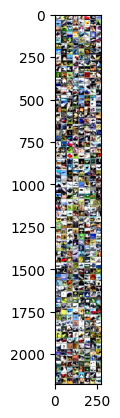

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat   truck ship  plane car   truck frog  frog  bird  deer  frog  plane deer  truck car   car   horse cat   deer  ship  truck plane frog  ship  plane cat   bird  bird  frog  frog  plane truck cat   bird  ship  bird  bird  deer  bird  frog  ship  deer  deer  truck truck deer  horse cat   dog   truck truck dog   deer  car   dog   car   dog   dog   deer  truck bird  frog  ship  dog   ship  dog   frog  ship  car   dog   car   horse ship  frog  deer  deer  ship  cat   cat   frog  horse ship  horse car   car   truck bird  bird  dog   ship  truck cat   ship  deer  deer  dog   car   ship  dog   horse deer  cat   deer  car   dog   plane bird  truck cat   cat   cat   ship  horse frog  plane dog   bird  truck frog  dog   car   car   horse plane truck cat   bird  car   cat   car   deer  car   ship  horse plane frog  dog   truck deer  bird  car   deer  hors

In [ ]:
# Check some images

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

# img = np.moveaxis(images[0].numpy(), 0, -1)
# plt.imshow(img)

def imshow(img):
        img = img / 2 + 0.5  # Unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))



# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Define the model

In [ ]:
dropout_value = 0.1

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Conv Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = b x 8 x 30 x 30

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 28

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # Conv Block 2 -------------------
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 22

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 20

        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 18


        # Conv Block 3 ---------------------
        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 18
        self.conv10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 16

        self.conv11 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 14

        self.conv12 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 12


        # Conv Block 4
        self.conv13 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 12
        self.conv14 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        self.conv15 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        self.conv16 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 6


        # Output
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.conv17 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.Dropout(dropout_value)
            # nn.ReLU()
        ) # output_size = 7



    def forward(self, x):
        # block1
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # block2
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)

        # block3
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.conv11(x)
        x = self.conv12(x)

        # block4
        x = self.conv13(x)
        x = self.conv14(x)
        x = self.conv15(x)
        x = self.conv16(x)

        # Output
        x = self.gap(x)
        x = self.conv17(x)
        x = x.view(-1, 10)

        return F.log_softmax(x, dim=-1)




## Model Summary

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             432
              ReLU-2           [-1, 16, 30, 30]               0
       BatchNorm2d-3           [-1, 16, 30, 30]              32
           Dropout-4           [-1, 16, 30, 30]               0
            Conv2d-5           [-1, 32, 28, 28]           4,608
              ReLU-6           [-1, 32, 28, 28]               0
       BatchNorm2d-7           [-1, 32, 28, 28]              64
           Dropout-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 32, 26, 26]           9,216
             ReLU-10           [-1, 32, 26, 26]               0
      BatchNorm2d-11           [-1, 32, 26, 26]              64
          Dropout-12           [-1, 32, 26, 26]               0
           Conv2d-13           [-1, 64, 24, 24]          18,432
             ReLU-14           [-1

## Train and Test loops

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Training

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 70
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=1.8166239261627197 Batch_id=97 Accuracy=24.11: 100%|██████████| 98/98 [00:16<00:00,  5.93it/s]



Test set: Average loss: 1.8382, Accuracy: 3247/10000 (32.47%)

EPOCH: 1


Loss=1.4659173488616943 Batch_id=97 Accuracy=39.08: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]



Test set: Average loss: 1.5516, Accuracy: 4290/10000 (42.90%)

EPOCH: 2


Loss=1.3786046504974365 Batch_id=97 Accuracy=46.84: 100%|██████████| 98/98 [00:15<00:00,  6.18it/s]



Test set: Average loss: 1.4134, Accuracy: 4921/10000 (49.21%)

EPOCH: 3


Loss=1.3165898323059082 Batch_id=97 Accuracy=51.64: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s]



Test set: Average loss: 1.3103, Accuracy: 5275/10000 (52.75%)

EPOCH: 4


Loss=1.2512311935424805 Batch_id=97 Accuracy=54.81: 100%|██████████| 98/98 [00:14<00:00,  6.65it/s]



Test set: Average loss: 1.2192, Accuracy: 5634/10000 (56.34%)

EPOCH: 5


Loss=1.1437915563583374 Batch_id=97 Accuracy=57.77: 100%|██████████| 98/98 [00:14<00:00,  6.60it/s]



Test set: Average loss: 1.1632, Accuracy: 5854/10000 (58.54%)

EPOCH: 6


Loss=1.1116483211517334 Batch_id=97 Accuracy=59.72: 100%|██████████| 98/98 [00:14<00:00,  6.64it/s]



Test set: Average loss: 1.1260, Accuracy: 5952/10000 (59.52%)

EPOCH: 7


Loss=1.1491167545318604 Batch_id=97 Accuracy=61.44: 100%|██████████| 98/98 [00:14<00:00,  6.57it/s]



Test set: Average loss: 1.1028, Accuracy: 6110/10000 (61.10%)

EPOCH: 8


Loss=1.0367991924285889 Batch_id=97 Accuracy=62.71: 100%|██████████| 98/98 [00:15<00:00,  6.48it/s]



Test set: Average loss: 1.0668, Accuracy: 6201/10000 (62.01%)

EPOCH: 9


Loss=0.9880194664001465 Batch_id=97 Accuracy=63.73: 100%|██████████| 98/98 [00:14<00:00,  6.72it/s]



Test set: Average loss: 1.0189, Accuracy: 6344/10000 (63.44%)

EPOCH: 10


Loss=1.02128005027771 Batch_id=97 Accuracy=64.85: 100%|██████████| 98/98 [00:14<00:00,  6.65it/s]



Test set: Average loss: 0.9738, Accuracy: 6534/10000 (65.34%)

EPOCH: 11


Loss=0.939967930316925 Batch_id=97 Accuracy=66.04: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]



Test set: Average loss: 0.9757, Accuracy: 6550/10000 (65.50%)

EPOCH: 12


Loss=1.0123344659805298 Batch_id=97 Accuracy=66.81: 100%|██████████| 98/98 [00:14<00:00,  6.54it/s]



Test set: Average loss: 0.9252, Accuracy: 6701/10000 (67.01%)

EPOCH: 13


Loss=0.9413331151008606 Batch_id=97 Accuracy=67.53: 100%|██████████| 98/98 [00:15<00:00,  6.51it/s]



Test set: Average loss: 0.9312, Accuracy: 6740/10000 (67.40%)

EPOCH: 14


Loss=0.9134708642959595 Batch_id=97 Accuracy=68.25: 100%|██████████| 98/98 [00:14<00:00,  6.66it/s]



Test set: Average loss: 0.9242, Accuracy: 6692/10000 (66.92%)

EPOCH: 15


Loss=0.8327255249023438 Batch_id=97 Accuracy=68.76: 100%|██████████| 98/98 [00:14<00:00,  6.67it/s]



Test set: Average loss: 0.9251, Accuracy: 6785/10000 (67.85%)

EPOCH: 16


Loss=0.81147301197052 Batch_id=97 Accuracy=69.27: 100%|██████████| 98/98 [00:15<00:00,  6.52it/s]



Test set: Average loss: 0.9034, Accuracy: 6838/10000 (68.38%)

EPOCH: 17


Loss=0.784878134727478 Batch_id=97 Accuracy=70.02: 100%|██████████| 98/98 [00:15<00:00,  6.27it/s]



Test set: Average loss: 0.9055, Accuracy: 6816/10000 (68.16%)

EPOCH: 18


Loss=0.8513612151145935 Batch_id=97 Accuracy=70.47: 100%|██████████| 98/98 [00:15<00:00,  6.48it/s]



Test set: Average loss: 0.8575, Accuracy: 7038/10000 (70.38%)

EPOCH: 19


Loss=0.829104483127594 Batch_id=97 Accuracy=71.12: 100%|██████████| 98/98 [00:16<00:00,  6.04it/s]



Test set: Average loss: 0.8422, Accuracy: 7087/10000 (70.87%)

EPOCH: 20


Loss=0.7768544554710388 Batch_id=97 Accuracy=71.24: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]



Test set: Average loss: 0.8456, Accuracy: 7077/10000 (70.77%)

EPOCH: 21


Loss=0.7622113227844238 Batch_id=97 Accuracy=71.82: 100%|██████████| 98/98 [00:16<00:00,  6.11it/s]



Test set: Average loss: 0.8318, Accuracy: 7088/10000 (70.88%)

EPOCH: 22


Loss=0.7256836891174316 Batch_id=97 Accuracy=72.38: 100%|██████████| 98/98 [00:15<00:00,  6.32it/s]



Test set: Average loss: 0.8292, Accuracy: 7072/10000 (70.72%)

EPOCH: 23


Loss=0.8359721899032593 Batch_id=97 Accuracy=72.69: 100%|██████████| 98/98 [00:15<00:00,  6.19it/s]



Test set: Average loss: 0.8257, Accuracy: 7175/10000 (71.75%)

EPOCH: 24


Loss=0.8505406975746155 Batch_id=97 Accuracy=73.01: 100%|██████████| 98/98 [00:14<00:00,  6.59it/s]



Test set: Average loss: 0.8119, Accuracy: 7158/10000 (71.58%)

EPOCH: 25


Loss=0.8291763067245483 Batch_id=97 Accuracy=73.33: 100%|██████████| 98/98 [00:15<00:00,  6.30it/s]



Test set: Average loss: 0.8018, Accuracy: 7279/10000 (72.79%)

EPOCH: 26


Loss=0.7007416486740112 Batch_id=97 Accuracy=73.79: 100%|██████████| 98/98 [00:16<00:00,  6.02it/s]



Test set: Average loss: 0.8078, Accuracy: 7247/10000 (72.47%)

EPOCH: 27


Loss=0.7511768341064453 Batch_id=97 Accuracy=73.81: 100%|██████████| 98/98 [00:15<00:00,  6.26it/s]



Test set: Average loss: 0.7848, Accuracy: 7334/10000 (73.34%)

EPOCH: 28


Loss=0.8407801389694214 Batch_id=97 Accuracy=74.27: 100%|██████████| 98/98 [00:15<00:00,  6.17it/s]



Test set: Average loss: 0.8143, Accuracy: 7238/10000 (72.38%)

EPOCH: 29


Loss=0.6056861877441406 Batch_id=97 Accuracy=74.46: 100%|██████████| 98/98 [00:15<00:00,  6.25it/s]



Test set: Average loss: 0.7946, Accuracy: 7303/10000 (73.03%)

EPOCH: 30


Loss=0.6193369626998901 Batch_id=97 Accuracy=74.61: 100%|██████████| 98/98 [00:15<00:00,  6.18it/s]



Test set: Average loss: 0.7937, Accuracy: 7277/10000 (72.77%)

EPOCH: 31


Loss=0.8134973645210266 Batch_id=97 Accuracy=75.23: 100%|██████████| 98/98 [00:17<00:00,  5.62it/s]



Test set: Average loss: 0.7563, Accuracy: 7410/10000 (74.10%)

EPOCH: 32


Loss=0.7307394742965698 Batch_id=97 Accuracy=75.28: 100%|██████████| 98/98 [00:15<00:00,  6.18it/s]



Test set: Average loss: 0.7560, Accuracy: 7416/10000 (74.16%)

EPOCH: 33


Loss=0.7878702878952026 Batch_id=97 Accuracy=75.42: 100%|██████████| 98/98 [00:16<00:00,  5.82it/s]



Test set: Average loss: 0.7259, Accuracy: 7513/10000 (75.13%)

EPOCH: 34


Loss=0.6994805932044983 Batch_id=97 Accuracy=75.58: 100%|██████████| 98/98 [00:16<00:00,  6.12it/s]



Test set: Average loss: 0.7435, Accuracy: 7470/10000 (74.70%)

EPOCH: 35


Loss=0.7737385034561157 Batch_id=97 Accuracy=76.16: 100%|██████████| 98/98 [00:16<00:00,  5.97it/s]



Test set: Average loss: 0.7281, Accuracy: 7554/10000 (75.54%)

EPOCH: 36


Loss=0.7078880667686462 Batch_id=97 Accuracy=76.29: 100%|██████████| 98/98 [00:16<00:00,  6.12it/s]



Test set: Average loss: 0.7483, Accuracy: 7439/10000 (74.39%)

EPOCH: 37


Loss=0.7152304649353027 Batch_id=97 Accuracy=76.35: 100%|██████████| 98/98 [00:16<00:00,  5.95it/s]



Test set: Average loss: 0.7298, Accuracy: 7503/10000 (75.03%)

EPOCH: 38


Loss=0.6825476288795471 Batch_id=97 Accuracy=76.45: 100%|██████████| 98/98 [00:16<00:00,  6.09it/s]



Test set: Average loss: 0.7204, Accuracy: 7553/10000 (75.53%)

EPOCH: 39


Loss=0.6819760203361511 Batch_id=97 Accuracy=76.96: 100%|██████████| 98/98 [00:16<00:00,  5.78it/s]



Test set: Average loss: 0.7031, Accuracy: 7589/10000 (75.89%)

EPOCH: 40


Loss=0.6925296783447266 Batch_id=97 Accuracy=76.89: 100%|██████████| 98/98 [00:15<00:00,  6.13it/s]



Test set: Average loss: 0.7465, Accuracy: 7466/10000 (74.66%)

EPOCH: 41


Loss=0.6542069315910339 Batch_id=97 Accuracy=77.01: 100%|██████████| 98/98 [00:16<00:00,  5.96it/s]



Test set: Average loss: 0.7284, Accuracy: 7522/10000 (75.22%)

EPOCH: 42


Loss=0.6431178450584412 Batch_id=97 Accuracy=77.68: 100%|██████████| 98/98 [00:16<00:00,  6.04it/s]



Test set: Average loss: 0.7160, Accuracy: 7583/10000 (75.83%)

EPOCH: 43


Loss=0.605074942111969 Batch_id=97 Accuracy=77.65: 100%|██████████| 98/98 [00:15<00:00,  6.20it/s]



Test set: Average loss: 0.6857, Accuracy: 7657/10000 (76.57%)

EPOCH: 44


Loss=0.582892894744873 Batch_id=97 Accuracy=77.69: 100%|██████████| 98/98 [00:16<00:00,  6.10it/s]



Test set: Average loss: 0.7021, Accuracy: 7622/10000 (76.22%)

EPOCH: 45


Loss=0.6713039875030518 Batch_id=97 Accuracy=77.53: 100%|██████████| 98/98 [00:15<00:00,  6.14it/s]



Test set: Average loss: 0.6997, Accuracy: 7625/10000 (76.25%)

EPOCH: 46


Loss=0.5081309080123901 Batch_id=97 Accuracy=77.94: 100%|██████████| 98/98 [00:16<00:00,  6.10it/s]



Test set: Average loss: 0.6819, Accuracy: 7649/10000 (76.49%)

EPOCH: 47


Loss=0.5266565680503845 Batch_id=97 Accuracy=78.03: 100%|██████████| 98/98 [00:16<00:00,  6.11it/s]



Test set: Average loss: 0.6938, Accuracy: 7639/10000 (76.39%)

EPOCH: 48


Loss=0.6426553130149841 Batch_id=97 Accuracy=78.20: 100%|██████████| 98/98 [00:15<00:00,  6.15it/s]



Test set: Average loss: 0.6845, Accuracy: 7663/10000 (76.63%)

EPOCH: 49


Loss=0.5553821325302124 Batch_id=97 Accuracy=78.80: 100%|██████████| 98/98 [00:15<00:00,  6.22it/s]



Test set: Average loss: 0.6987, Accuracy: 7643/10000 (76.43%)

EPOCH: 50


Loss=0.5897436738014221 Batch_id=97 Accuracy=78.75: 100%|██████████| 98/98 [00:16<00:00,  5.97it/s]



Test set: Average loss: 0.6902, Accuracy: 7643/10000 (76.43%)

EPOCH: 51


Loss=0.6416627168655396 Batch_id=97 Accuracy=78.76: 100%|██████████| 98/98 [00:15<00:00,  6.15it/s]



Test set: Average loss: 0.7086, Accuracy: 7645/10000 (76.45%)

EPOCH: 52


Loss=0.6252762675285339 Batch_id=97 Accuracy=78.98: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s]



Test set: Average loss: 0.6713, Accuracy: 7740/10000 (77.40%)

EPOCH: 53


Loss=0.6948004364967346 Batch_id=97 Accuracy=78.79: 100%|██████████| 98/98 [00:15<00:00,  6.18it/s]



Test set: Average loss: 0.6897, Accuracy: 7652/10000 (76.52%)

EPOCH: 54


Loss=0.5968473553657532 Batch_id=97 Accuracy=78.90: 100%|██████████| 98/98 [00:16<00:00,  5.89it/s]



Test set: Average loss: 0.6512, Accuracy: 7800/10000 (78.00%)

EPOCH: 55


Loss=0.5978857278823853 Batch_id=97 Accuracy=79.42: 100%|██████████| 98/98 [00:16<00:00,  6.11it/s]



Test set: Average loss: 0.6726, Accuracy: 7729/10000 (77.29%)

EPOCH: 56


Loss=0.5313359498977661 Batch_id=97 Accuracy=79.42: 100%|██████████| 98/98 [00:15<00:00,  6.25it/s]



Test set: Average loss: 0.6708, Accuracy: 7715/10000 (77.15%)

EPOCH: 57


Loss=0.5855317115783691 Batch_id=97 Accuracy=79.64: 100%|██████████| 98/98 [00:15<00:00,  6.43it/s]



Test set: Average loss: 0.6690, Accuracy: 7741/10000 (77.41%)

EPOCH: 58


Loss=0.6892649531364441 Batch_id=97 Accuracy=79.46: 100%|██████████| 98/98 [00:16<00:00,  5.96it/s]



Test set: Average loss: 0.6606, Accuracy: 7737/10000 (77.37%)

EPOCH: 59


Loss=0.551240086555481 Batch_id=97 Accuracy=79.73: 100%|██████████| 98/98 [00:15<00:00,  6.25it/s]



Test set: Average loss: 0.6713, Accuracy: 7733/10000 (77.33%)

EPOCH: 60


Loss=0.5954095721244812 Batch_id=97 Accuracy=79.73: 100%|██████████| 98/98 [00:14<00:00,  6.54it/s]



Test set: Average loss: 0.6603, Accuracy: 7748/10000 (77.48%)

EPOCH: 61


Loss=0.5443644523620605 Batch_id=97 Accuracy=79.65: 100%|██████████| 98/98 [00:15<00:00,  6.51it/s]



Test set: Average loss: 0.6710, Accuracy: 7693/10000 (76.93%)

EPOCH: 62


Loss=0.5225254893302917 Batch_id=97 Accuracy=79.94: 100%|██████████| 98/98 [00:15<00:00,  6.42it/s]



Test set: Average loss: 0.6491, Accuracy: 7794/10000 (77.94%)

EPOCH: 63


Loss=0.5843309760093689 Batch_id=97 Accuracy=80.18: 100%|██████████| 98/98 [00:14<00:00,  6.64it/s]



Test set: Average loss: 0.6509, Accuracy: 7805/10000 (78.05%)

EPOCH: 64


Loss=0.630469799041748 Batch_id=97 Accuracy=80.51: 100%|██████████| 98/98 [00:15<00:00,  6.51it/s]



Test set: Average loss: 0.6360, Accuracy: 7832/10000 (78.32%)

EPOCH: 65


Loss=0.5445153117179871 Batch_id=97 Accuracy=80.26: 100%|██████████| 98/98 [00:15<00:00,  6.50it/s]



Test set: Average loss: 0.6456, Accuracy: 7818/10000 (78.18%)

EPOCH: 66


Loss=0.5243894457817078 Batch_id=97 Accuracy=80.25: 100%|██████████| 98/98 [00:14<00:00,  6.60it/s]



Test set: Average loss: 0.6457, Accuracy: 7814/10000 (78.14%)

EPOCH: 67


Loss=0.5451947450637817 Batch_id=97 Accuracy=80.59: 100%|██████████| 98/98 [00:15<00:00,  6.24it/s]



Test set: Average loss: 0.6381, Accuracy: 7852/10000 (78.52%)

EPOCH: 68


Loss=0.543708086013794 Batch_id=97 Accuracy=80.63: 100%|██████████| 98/98 [00:14<00:00,  6.54it/s]



Test set: Average loss: 0.6577, Accuracy: 7791/10000 (77.91%)

EPOCH: 69


Loss=0.5466058850288391 Batch_id=97 Accuracy=80.69: 100%|██████████| 98/98 [00:14<00:00,  6.56it/s]



Test set: Average loss: 0.6371, Accuracy: 7865/10000 (78.65%)



## Accuracy and Loss curves

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")